In [16]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from tcn import TCN, tcn_full_summary

from model.data_parser import convert_jaad_dict_to_df, get_JAAD_data

In [18]:
#Load data
data_dir = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/JAAD_per_person/"

X, Y = convert_jaad_dict_to_df(get_JAAD_data(data_dir))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Starting to read JAAD json files!


# Random forest

In [13]:
from skmultilearn.problem_transform import ClassifierChain

from sklearn.ensemble import RandomForestClassifier

classifier = ClassifierChain(
        classifier=RandomForestClassifier(n_estimators=100),
        require_dense=[False, True]
    )

classifier.fit(X_train, Y_train)
# predict
predictions = classifier.predict(X_test)

print(accuracy_score(Y_test, predictions))

0.04928611760909898
0.8362507058159232


In [16]:
classifier.fit(X_train, Y_train)
predictions = classifier.predict(X_test)
df = pd.DataFrame.sparse.from_spmatrix(predictions)

0.04839880616278132
0.8384286520932483


TypeError: len() of unsized object

In [28]:
print(metrics.hamming_loss(Y_test, df))
print(metrics.accuracy_score(Y_test, df))
i=0
for col in df:
    df = df.rename(columns={col: str(int(col))})
for col in Y_test.columns:
    print(col + " accury:")
    print(metrics.accuracy_score(Y_test[col], df[str(i)]) )
    i += 1

0.04839880616278132
0.8384286520932483
look accury:
0.9244171977091232
action accury:
0.9409534564814068
cross accury:
0.8945712672420747
hand_gesture accury:
0.9983867064612406
nod accury:
0.9996773412922482


# LSTM

In [4]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [6]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.6, name='f1_score', dtype=None), 'accuracy'])

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2322 - f1_score: 0.7563 - accuracy: 0.7407
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3092/3092 [==============================] - 120s 37ms/step - loss: 0.2322 - f1_score: 0.7563 - accuracy: 0.7407
Epoch 2/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2294 - f1_score: 0.7575 - accuracy: 0.7407
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3092/3092 [==============================] - 93s 30ms/step - loss: 0.2294 - f1_score: 0.7575 - accuracy: 0.7407
Epoch 3/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2226 - f1_score: 0.7574 - accuracy: 0.7406
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/sav

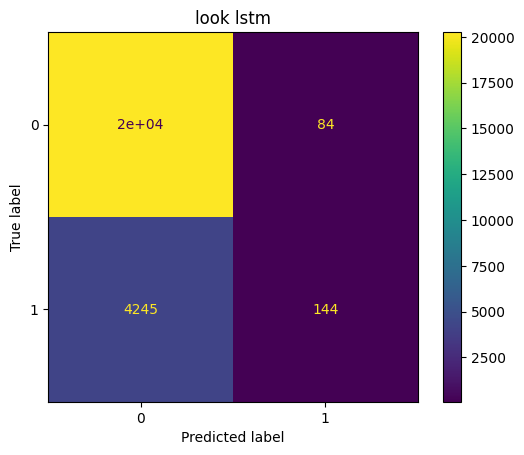

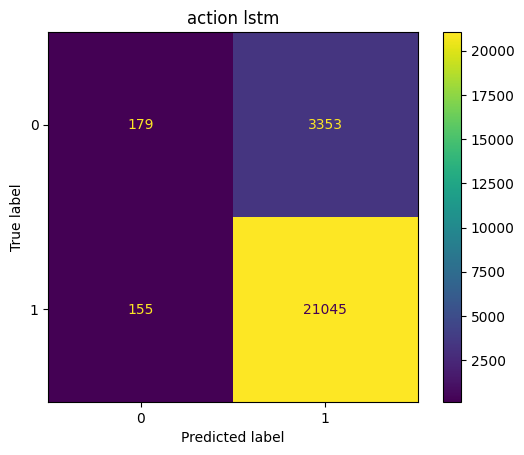

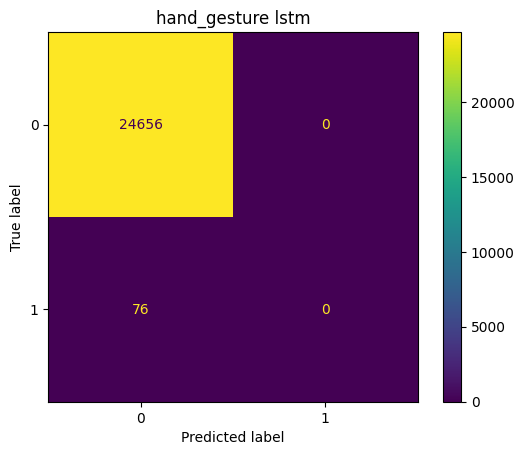

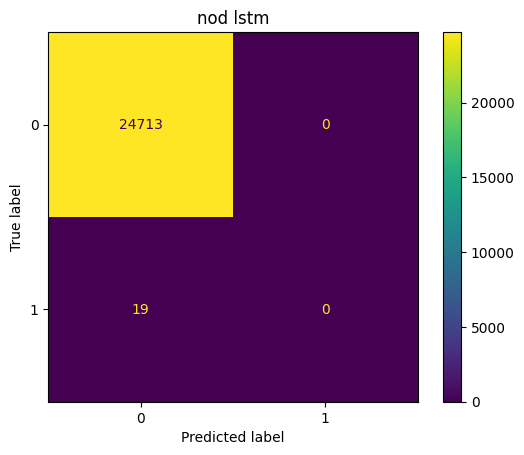

In [7]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    cm = confusion_matrix((Y_test.to_numpy())[:, i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

In [14]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_05_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [8]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.5, name='f1_score', dtype=None)])

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2317 - f1_score: 0.7573
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3092/3092 [==============================] - 97s 30ms/step - loss: 0.2317 - f1_score: 0.7574
Epoch 2/11
3092/3092 [==============================] - ETA: 0s - loss: 0.2292 - f1_score: 0.7575
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3092/3092 [==============================] - 106s 34ms/step - loss: 0.2292 - f1_score: 0.7575
Epoch 3/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2289 - f1_score: 0.7575
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3092/3092 [==============================] - 96s 31ms/step - loss:

Accuracy: 0.8277939511563965


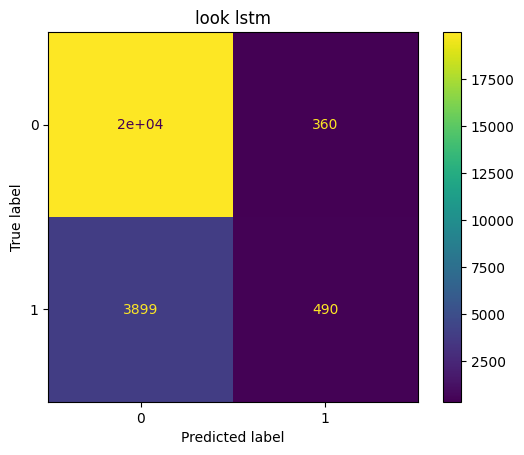

Accuracy: 0.8573508005822417


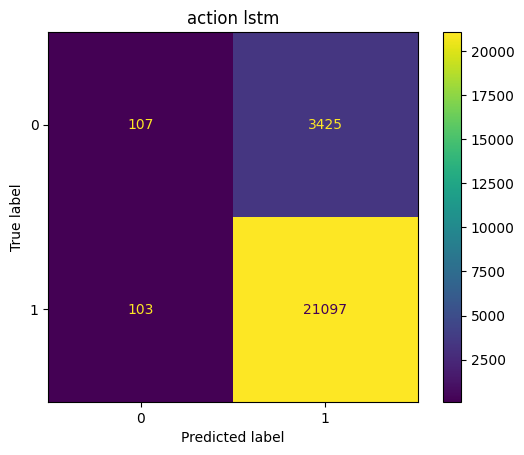

Accuracy: 0.9969270580624292


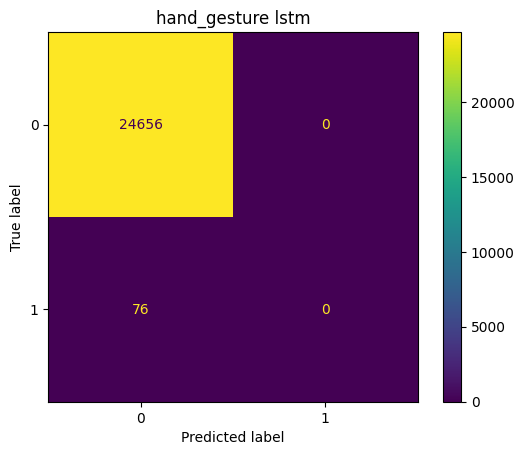

Accuracy: 0.9992317645156074


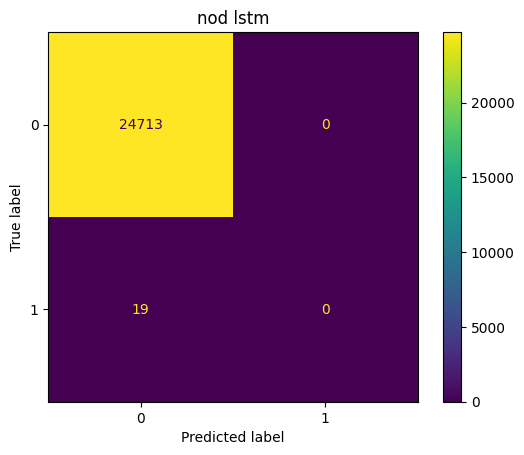

In [10]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

# TCN

In [11]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_tcn_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2138 - f1_score: 0.7576
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 371s 363ms/step - loss: 0.2138 - f1_score: 0.7576
Epoch 2/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2044 - f1_score: 0.7592
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 375s 375ms/step - loss: 0.2044 - f1_score: 0.7592
Epoch 3/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2002 - f1_score: 0.7643
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_rec

Accuracy: 0.829249555232088


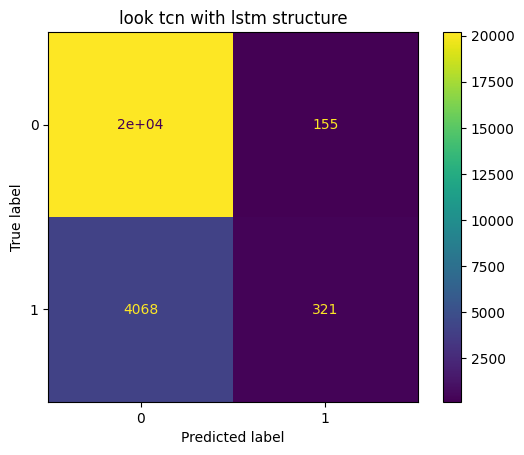

Accuracy: 0.8634158175642892


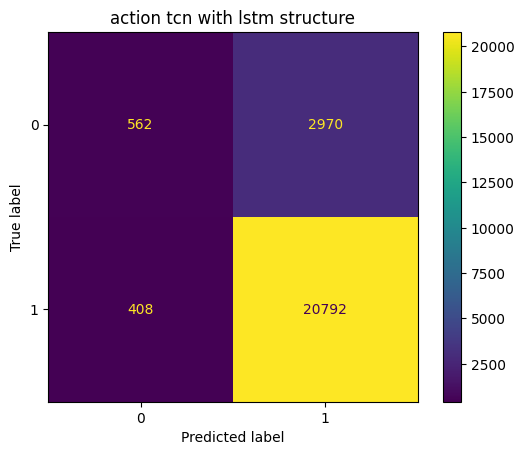

Accuracy: 0.9969270580624292


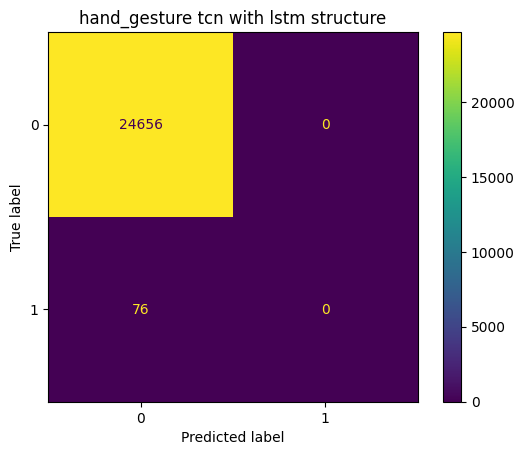

Accuracy: 0.9992317645156074


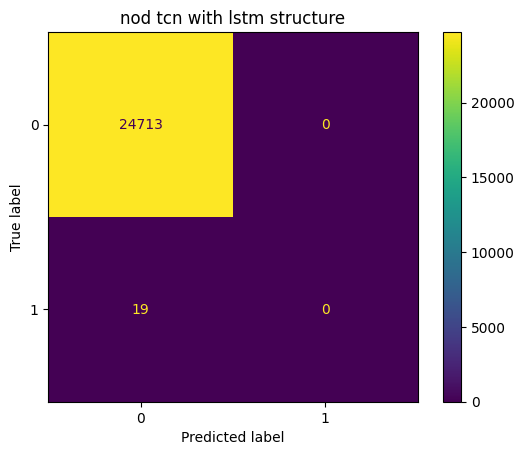

In [13]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [14]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_lstm_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.5, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2176 - f1_score: 0.7598
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 179s 175ms/step - loss: 0.2176 - f1_score: 0.7598
Epoch 2/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2049 - f1_score: 0.7655
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 192s 192ms/step - loss: 0.2049 - f1_score: 0.7655
Epoch 3/8
 999/1000 [============================>.] - ETA: 0s - loss: 0.2016 - f1_score: 0.7760
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_rec

Accuracy: 0.8334546336729742


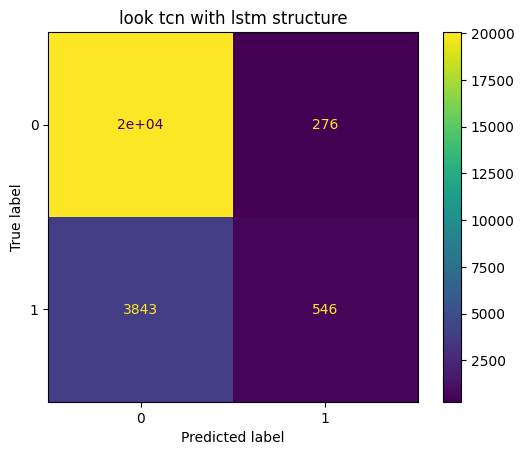

Accuracy: 0.8634562510108361


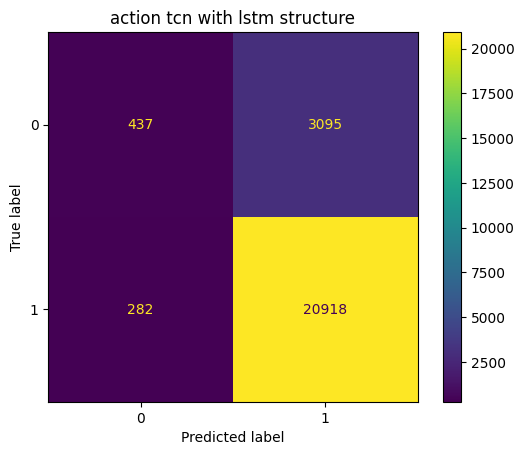

Accuracy: 0.9969270580624292


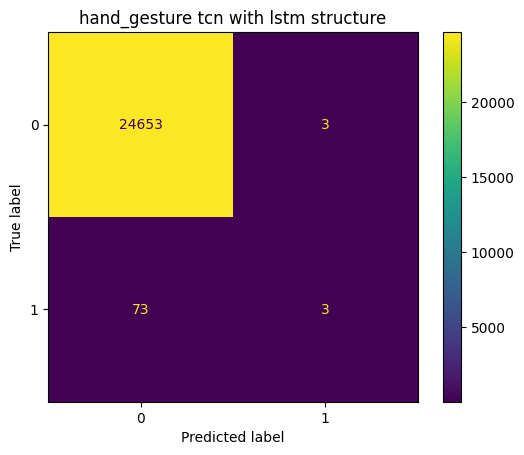

Accuracy: 0.9992317645156074


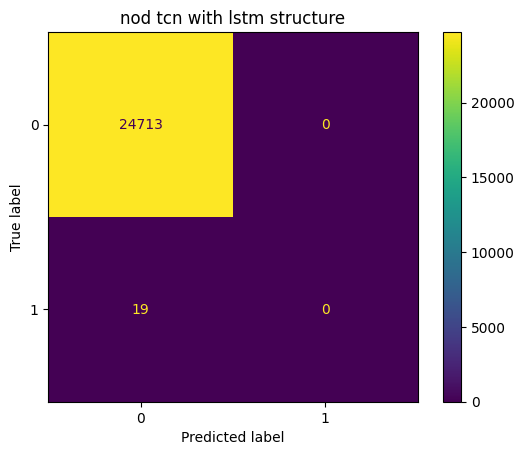

In [20]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [21]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [22]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

history = m.fit(X_train, Y_train,  epochs=10, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/10


KeyboardInterrupt: 

In [ ]:
i = 0
for col in Y_train.columns:

    cm = confusion_matrix((Y_test.to_numpy())[:, i], np.round(predictions[:, i]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn')
    plt.show()
    i += 1